In [1]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from lightgbm import plot_importance

# 파라미터 auto 튜닝용
import optuna
from optuna import Trial, visualization 
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic') # 한글 깨짐

sns.set(font="Malgun Gothic",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

- 이전 28일 피쳐를 구할 수 없는 2020-01-01 ~ 2020-01-28은 train에서 제외

In [2]:
def trainTestSplit(data):
    x_train=data['2020-01-29':'2022-08-31'].drop('신고건수',axis=1)
    y_train=np.log(data['2020-01-29':'2022-08-31']['신고건수']+0.001)
    x_test=data['2022-09-01':].drop('신고건수',axis=1)
    y_test=np.log(data['2022-09-01':]['신고건수']+0.001)
    
    return x_train, y_train, x_test, y_test

In [3]:
#def objectiveRF(trial: Trial, X, y, test):
def objectiveRF(trial: Trial, X_train, y_train, X_valid, y_valid):    
    param = {
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
        'max_depth' : trial.suggest_int('max_depth', 1, 32),
        'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 200),
        'n_estimators' : trial.suggest_int('n_estimators', 1, 1100),
        'random_state':85
        #'max_depth' : 16,
        #'n_estimators' : 93,
    }
    
    model = RandomForestRegressor(**param)
    rf_model = model.fit(X_train, y_train)

    one=model_lgb.predict(X_valid)
    two=y_valid
    score = mean_squared_error(np.exp(one),np.exp(two) , squared=False)
    return score


#def objectiveLGB(trial: Trial, X, y, test):
def objectiveLGB(trial: Trial, X_train, y_train, X_valid, y_valid):  
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256, step=1, log=True), 
        'max_depth': trial.suggest_int('max_depth', 1, 10, step=1, log=False), 
        'learning_rate': trial.suggest_float('learning_rate', 0.07, 0.1, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 8, 1024, step=1, log=True), 
        'objective': 'regression', 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=1, log=False), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'random_state': 85
    }
    
    model = lgb.LGBMRegressor(**param)
    model_lgb = model.fit(X_train, y_train, verbose=False)

    one=model_lgb.predict(X_valid)
    two=y_valid
    score = mean_squared_error(np.exp(one),np.exp(two) , squared=False)

    return score

* * *

# 데이터 로딩

In [5]:
data=pd.read_csv("08_7일&1달.csv", encoding='cp949')
data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')
data=data.set_index('date')
data.head()

,신고건수,Week,정기적_이벤트,비정기적_이벤트,뉴스개수,금리,누적확진자수,확진자수,소비자물가지수,비트코인거래량,...,이전4주_뉴스개수,이전4주_확진자수,이전4주_비트코인거래량,이전4주_네이버_보이스피싱,이전4주_다음카카오_보이스피싱,이전4주_구글_보이스피싱,이전4주_네이버_대출,이전4주_다음카카오_대출,이전4주_구글_대출검색,이전4주건수_평균
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4,1,0,0,NaN,1.25,NaN,NaN,100.09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,29,1,0,0,1.0,1.25,0.0,0.0,100.09,420280.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,31,1,0,0,3.0,1.25,0.0,0.0,100.09,632780.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,6,1,0,0,3.0,1.25,0.0,0.0,100.09,936290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,4,1,0,0,4.0,1.25,0.0,0.0,100.09,523910.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- trainTestSplit : train, test로 분리

In [6]:
x_train, y_train, x_test, y_test = trainTestSplit(data)

* * *

## optuna 이용하여 하이퍼 파라미터 탐색

In [7]:
## objectiveLGB : LightGBM의 파라미터 Auto 튜닝

#study = optuna.create_study(direction='minimize',sampler=TPESampler())
#study = optuna.create_study(direction='minimize',sampler=TPESampler())

# n_trials : 시도 횟수 (미 입력시 Key interrupt가 있을 때까지 무한 반복)
#study.optimize(lambda trial : objectiveLGB(trial, x_train,  y_train, x_test, y_test), n_trials=500)
#study.optimize(lambda trial : objectiveRF(trial, x_train,  y_train, x_test, y_test), n_trials=500)

#study.optimize(lambda trial : objectiveXGB(trial, x_train,  y_train, x_test, y_test), n_trials=50)

# 최적 파라미터 출력
#print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
print("done")

done


In [8]:
#print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

## 최적화된 LightGBM, RF 모델 학습
- 앞의 optuna를 통해 최적화된 하이퍼 파라미터 활용

In [9]:
model_lgb = lgb.LGBMRegressor(num_leaves=130, max_depth=1, learning_rate=0.07452804037861703,
                              n_estimators=220, class_weight='balanced',min_child_samples=11,
                              subsample=0.851299597974581,colsample_bytree=0.7336413720932892,
                              reg_alpha=0.3651988606430677,reg_lambda=0.4099010817461396 , random_state=85)
model_rf=RandomForestRegressor(max_depth=10,n_estimators=484,
                                min_samples_split=10, min_samples_leaf=2,max_leaf_nodes=167,
                                random_state=85)
model_rf.fit(x_train, y_train)
model_lgb.fit(x_train, y_train)
predictions_lgb = model_lgb.predict(x_test)
predictions_rf=model_rf.predict(x_test)

# train,test score 산출용
predictions_ens_train=(model_lgb.predict(x_train)+model_rf.predict(x_train))/2
predictions_ens=(predictions_lgb+predictions_rf)/2


pre_lgb=pd.DataFrame(predictions_lgb)
pre_lgb=pre_lgb.set_index(y_test.index)

pre_rf=pd.DataFrame(predictions_rf)
pre_rf=pre_rf.set_index(y_test.index)

print("LGBM model")
print('train_score :', model_lgb.score(x_train, y_train))
print('test_score :', model_lgb.score(x_test,y_test))
print("")
print("RF model")
print('train_score :', model_rf.score(x_train, y_train))
print('test_score :', model_rf.score(x_test,y_test))
print("")
print("RF/LGBM 산술평균 앙상블 모델")
print("train_score : "+ str(r2_score(y_train,predictions_ens_train)))
print("test_score : "+ str(r2_score(y_test,predictions_ens)))

LGBM model
train_score : 0.7604584533697092
test_score : 0.7411035443166034

RF model
train_score : 0.9298885317314164
test_score : 0.7407203295981772

RF/LGBM 산술평균 앙상블 모델
train_score : 0.8681569714848678
test_score : 0.7530591174287349


* * *

## 모델링 결과

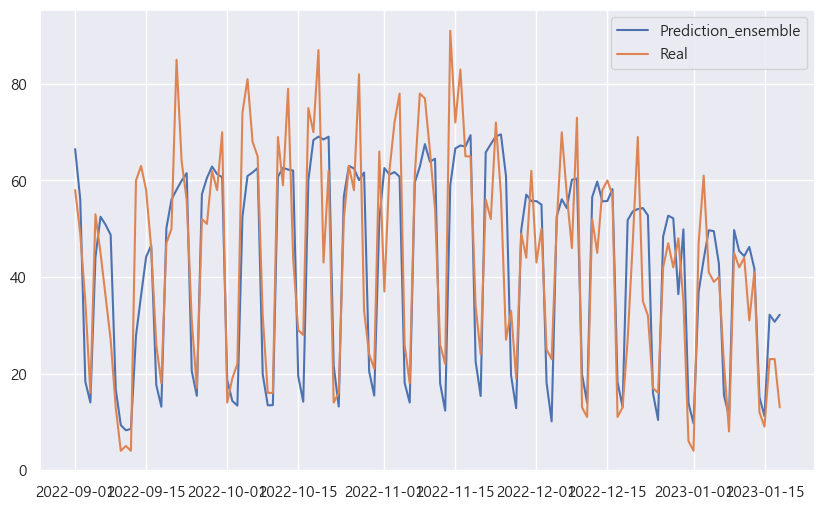

In [10]:
#pred=model_lgb.predict(y_test)
pred_lgb=pd.DataFrame(np.exp(predictions_lgb))
pred_lgb=pred_lgb.set_index(y_test.index)

pred_rf=pd.DataFrame(np.exp(predictions_rf))
pred_rf=pred_rf.set_index(y_test.index)

pred_ens=pd.DataFrame(np.exp(predictions_ens))
pred_ens=pred_ens.set_index(y_test.index)

y_test_ori=np.exp(y_test)

plt.figure(figsize=(10,6))
#plt.plot(training, label='Train')
#plt.plot(pred_lgb, label='Prediction_lgb')
#plt.plot(pred_rf, label='Prediction_rf')
plt.plot(pred_ens, label='Prediction_ensemble')
plt.plot(y_test_ori,label='Real')

temp=np.percentile(y_test, [90,75,60,45,30])
temp2=np.percentile(pred_ens, [90,75,60,45,30])

plt.legend()
plt.grid(True)
plt.show()

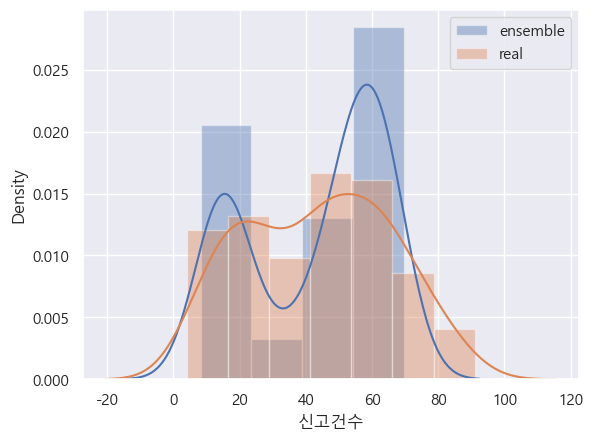

In [11]:
sns.distplot(pred_ens,label='ensemble')
sns.distplot(y_test_ori,label='real')
plt.legend()
plt.show()

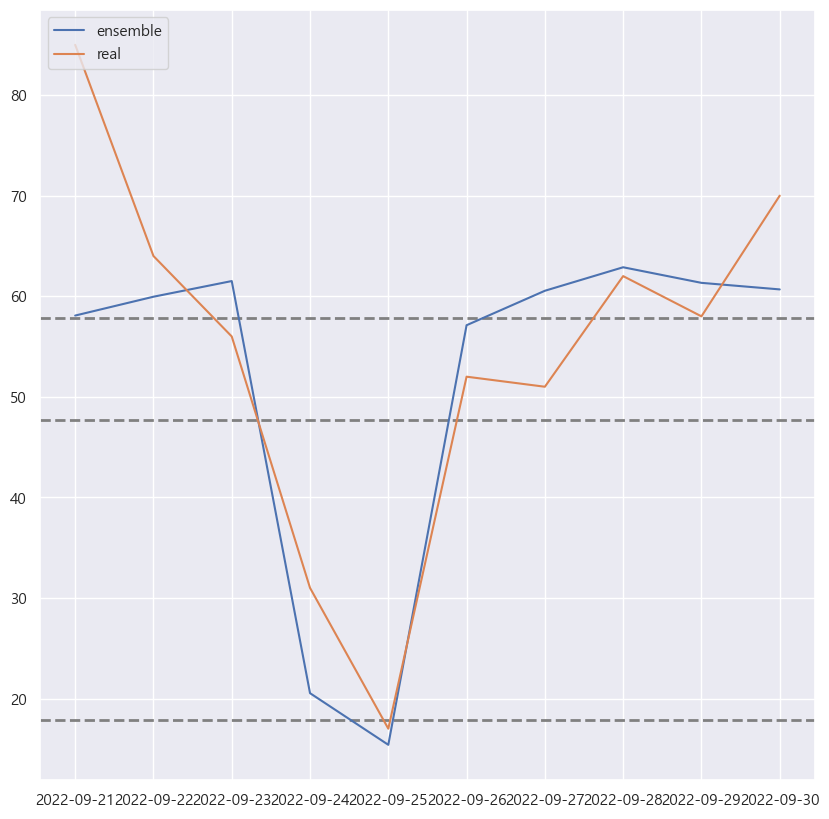

In [12]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.axhline(np.percentile(pred_ens['2022-09-01':'2022-09-30'], [75,50,25])[0], 0, 1, color='gray', linestyle='--', linewidth=2)
plt.axhline(np.percentile(pred_ens['2022-09-01':'2022-09-30'], [75,50,25])[1], 0, 1, color='gray', linestyle='--', linewidth=2)
plt.axhline(np.percentile(pred_ens['2022-09-01':'2022-09-30'], [75,50,25])[2], 0, 1, color='gray', linestyle='--', linewidth=2)
plt.plot(pred_ens['2022-09-21':'2022-09-30'],label='ensemble')
plt.plot(y_test_ori['2022-09-21':'2022-09-30'],label='real')
plt.legend(loc='upper left')
plt.show()

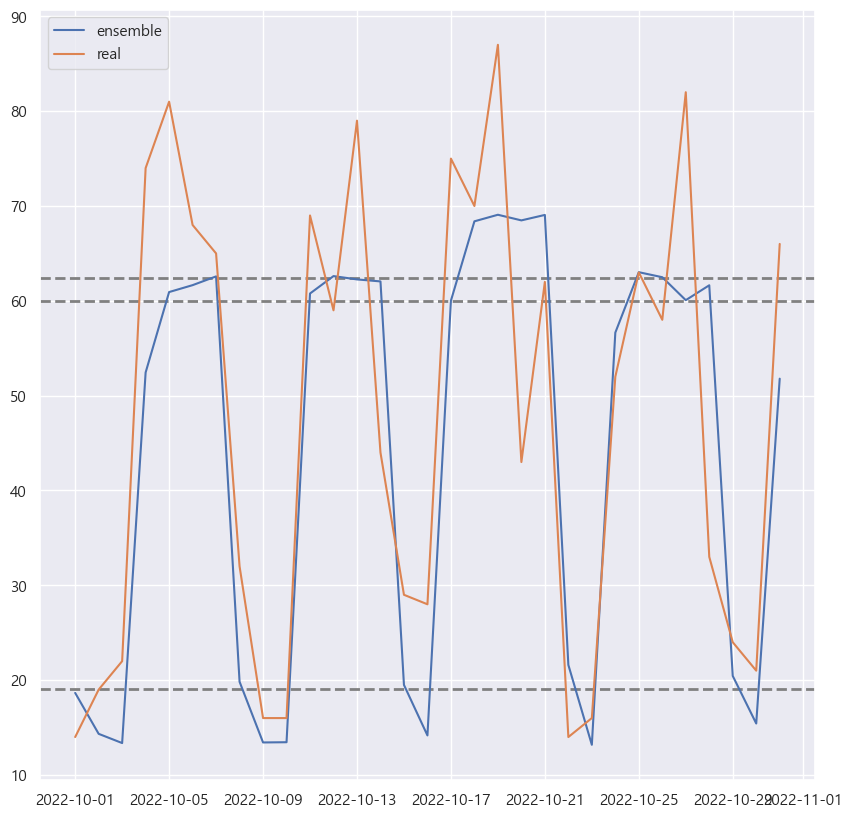

In [13]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.axhline(np.percentile(pred_ens['2022-10-01':'2022-10-31'], [75,50,25])[0], 0, 1, color='gray', linestyle='--', linewidth=2)
plt.axhline(np.percentile(pred_ens['2022-10-01':'2022-10-31'], [75,50,25])[1], 0, 1, color='gray', linestyle='--', linewidth=2)
plt.axhline(np.percentile(pred_ens['2022-10-01':'2022-10-31'], [75,50,25])[2], 0, 1, color='gray', linestyle='--', linewidth=2)
plt.plot(pred_ens['2022-10-01':'2022-10-31'],label='ensemble')
plt.plot(y_test_ori['2022-10-01':'2022-10-31'],label='real')
plt.legend(loc='upper left')
plt.show()

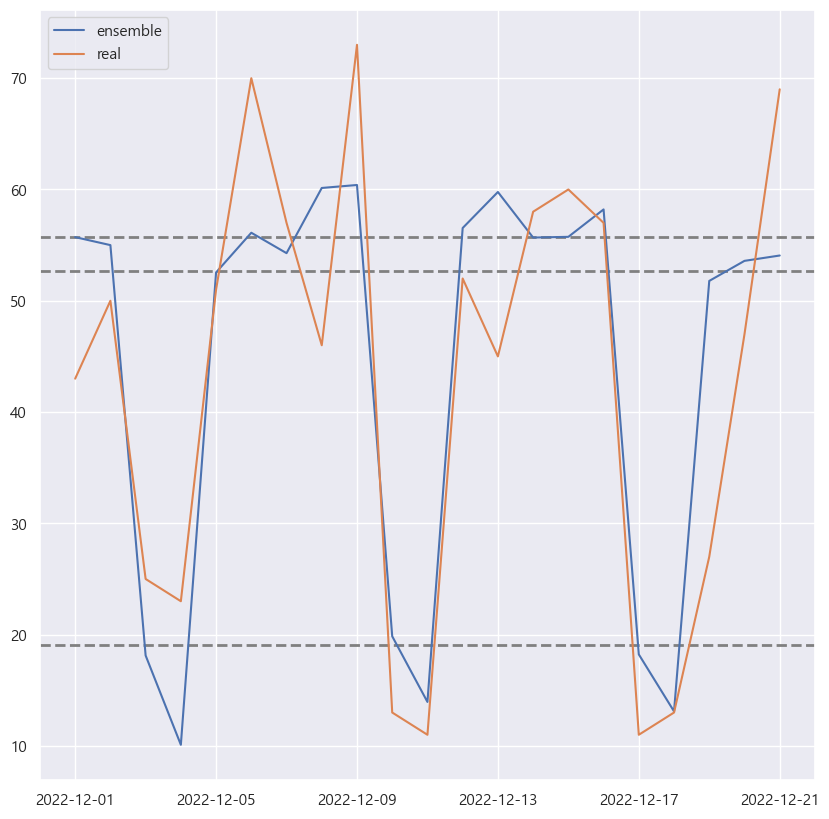

In [14]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.axhline(np.percentile(pred_ens['2022-12-01':'2022-12-31'], [75,50,25])[0], 0, 1, color='gray', linestyle='--', linewidth=2)
plt.axhline(np.percentile(pred_ens['2022-12-01':'2022-12-31'], [75,50,25])[1], 0, 1, color='gray', linestyle='--', linewidth=2)
plt.axhline(np.percentile(pred_ens['2022-12-01':'2022-12-31'], [75,50,25])[2], 0, 1, color='gray', linestyle='--', linewidth=2)
plt.plot(pred_ens['2022-12-01':'2022-12-21'],label='ensemble')
plt.plot(y_test_ori['2022-12-01':'2022-12-21'],label='real')
plt.legend(loc='upper left')
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

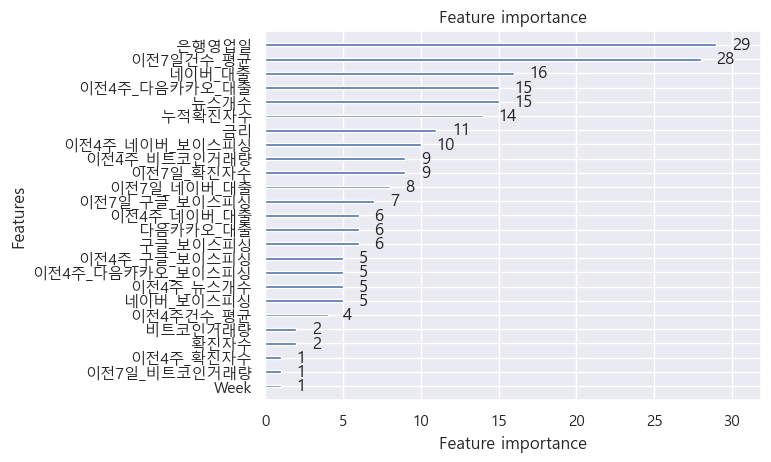

In [16]:
lgb.plot_importance(model_lgb)